# SPECFEM Users Workshop -- Day 2 (Oct. 6, 2022)


# TO DO (ctrl+f `!!!`):
- Add Day 2 slides (this cell)
- Background material (Section 1)
- Key SPECFEM3D differences for adjoint simulations (Section 3)
- Explain kernel figure (Section 3C)
- Add kernel summation example (using xcombine_sem)

## Day 2a: Kernels and Adjoint Simulations 

- In this notebook we will build upon the [Day 1 (Forward Simulation)](https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/day_1b_forward_simulations.ipynb) training 
- **Objective**: I ntroduce the concepts of misfit, adjoint sources, and kernels to understand adjoint simulations  
- Adjoint simulations are key for performing seismic imaging (Day 3) as their results guide iterative model updates during the inverse problem  
- These instructions should be run from inside the Docker container, using Jupyter Lab (see *Docker Preamble* in Day 0). 

-----------

**Relevant Links:** 
- Day 2 Slides !!! ADD THIS !!!
- Today's Notebook: https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/day_2a_kernels.ipynb
- Completed Notebook https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_2a_kernels.ipynb
- Day 0 Notebook (Container Testing): https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_0_container_testing.ipynb
- Day 1A Notebook (Intro SPECFEM): https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_1a_intro_specfem2d.ipynb
- Day 1B Notebook (Fwd. Simulations): https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_1b_forward_simulations.ipynb

**Jupyter Quick Tips:**

- **Run cells** one-by-one by hitting the $\blacktriangleright$ button at the top, or by hitting `Shift + Enter`
- **Run all cells** by hitting the $\blacktriangleright\blacktriangleright$ button at the top, or by running `Run -> Run All Cells`
- **Currently running cells** that are still processing will have a `[*]` symbol next to them
- **Finished cells** will have a `[1]` symbol next to them. The number inside the brackets represents what order this cell has been run in.
- Commands that start with `!` are Bash commands (i.e., commands you would run from the terminal)
- Commands that start with `%` are Jupyter Magic commands.

-----------
## 1) Setting Up a SPECFEM2D Working Directory

- As with Day 1, we will want to set up a clean working directory to run SPECFEM2D inside. 
- This will help us preserve our cloned repository and reduce file clutter  
- We will be doing all our work in the directory `/home/scoped/work/day_2`, all the following cells assume that we are in this directory

In [1]:
# Python packages we will use in this notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from scipy.integrate import simps
from seisflows.tools.specfem import Model 

In [2]:
# Make correct dir. and move there
! mkdir -p /home/scoped/work/day_2/specfem2d_workdir
%cd /home/scoped/work/day_2/specfem2d_workdir

# Symlink the executables and copy the relevant DATA/ directory
! ln -s /home/scoped/specfem2d/bin .
! cp -r /home/scoped/specfem2d/EXAMPLES/Tape2007/DATA .
! mkdir OUTPUT_FILES

! ls

/home/scoped/work/day_2/specfem2d_workdir
bin  DATA  OUTPUT_FILES


## 2) Experimental Setup: Tape et al. 2007 Example Problem

- As with Day 1, we will be working with an Example problem from the [Tape et al. 2007 GJI publication](https://academic.oup.com/gji/article/168/3/1105/929373)
- We will be revisiting the **homogeneous halfspace** model we saw in Day 1.
- We will also look at a **perturbation checkerboard** model which defines a smooth checkerboard with $\pm$10\% velocity perturbations  
- The perturbation checkerboard is overlain ontop of the homogeneous halfspace model  
- Here we use Python (NumPy and Matplotlib) to visualize the Example problem setup

In [ ]:
%cd /home/scoped/work/day_2/specfem2d_workdir

### a) The Homogeneous Halfspace Model

- The homogeneous halfspace model in this example is defined in the `Par_file`, 
- The homogeneous halfspace model defines a region with P-wave velocity $V_p=$5.8km/s and S-wave velocity $V_s$=3.5km/s. 
- This is the same model that we looked at in Day 1B 
- We will not explore the halfspace model in as much detail as Day 1, but we plot it here for reference.

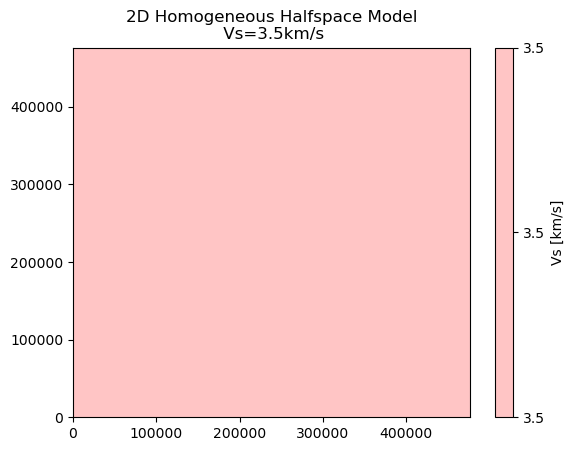

In [3]:
def plot_homogeneous_halfspace():
    """Plots a representation of the SPECFEM2D homogeneous halfspace model"""
    # Sets the X and Z dimensions of our mesh
    x = np.arange(0, 480000, 4000)
    z = np.arange(0, 480000, 4000)
    
    # Reformat the 1D arrays into 2D
    xv, zv = np.meshgrid(x, z)

    # Set a homogeneous value of Vs=3.5km/s 
    vs = 3.5 * np.ones(np.shape(xv))

    # Plot the arrays as a homogeneous halfspace
    plt.tricontourf(xv.flatten(), zv.flatten(), vs.flatten(), cmap="seismic_r", vmin=3.1, vmax=4.)
    plt.colorbar(label="Vs [km/s]", format="%.1f")
    plt.title("2D Homogeneous Halfspace Model\n Vs=3.5km/s")
    
# Calls the function we just defined
plot_homogeneous_halfspace()

### b) The Perturbation Checkerboard Model

- The checkerboard features smoothly varying 2D Gaussians which perturb the homogeneous halfspace model ($V_s$ and $V_p$) by roughly $\pm$10%  
- The checkerboard model is defined by an **external** velocity model file: *DATA/model_velocity.dat_checker*
- SPECFEM can read external files of various formats to define the velocity model
- First we'll have a look at the checkerboard model data file, and then we'll plot it directly.

The columns of the checkerboard model are defined: 
```bash
line_number x[m] z[m] density vp[m/s] vs[m/s]
```

In [4]:
# Look at the first few lines of the checkerboard
! head DATA/model_velocity.dat_checker

	0	    0.0000	    0.0000	2600.0000	5800.0000	3500.0000
	1	 2072.1000	    0.0000	2600.0000	5800.0000	3500.0000
	2	 6000.0000	    0.0000	2600.0000	5800.0000	3500.0000
	3	 9927.9000	    0.0000	2600.0000	5800.0000	3500.0000
	4	12000.0000	    0.0000	2600.0000	5800.0000	3500.0000
	5	    0.0000	 2072.1000	2600.0000	5800.0000	3500.0000
	6	 2072.1000	 2072.1000	2600.0000	5800.3000	3500.3000
	7	 6000.0000	 2072.1000	2600.0000	5800.8000	3501.0000
	8	 9927.9000	 2072.1000	2600.0000	5801.3000	3501.6000
	9	12000.0000	 2072.1000	2600.0000	5801.6000	3501.9000


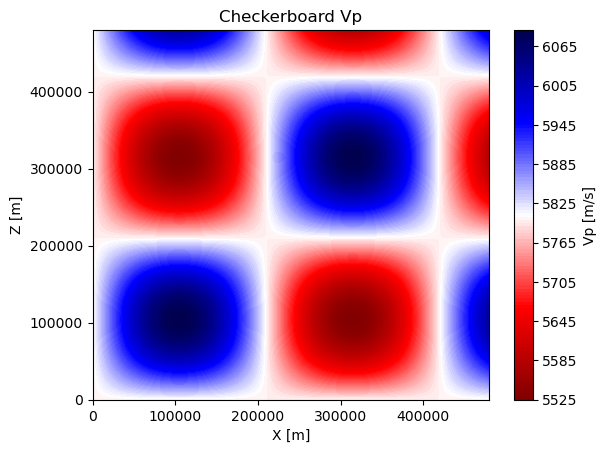

In [8]:
# Grab values of X, Z, Vs and Vp for plotting
data = np.genfromtxt("DATA/model_velocity.dat_checker", dtype=float, usecols=[1,2,4,5])
chkbd_x, chkbd_z, chkbd_vp, chkbd_vs = data.T

# Plotting Vp
plt.tricontourf(chkbd_x, chkbd_z, chkbd_vp, levels=125, cmap="seismic_r")
plt.xlabel("X [m]")
plt.ylabel("Z [m]")
plt.title("Checkerboard Vp")
plt.colorbar(label="Vp [m/s]")

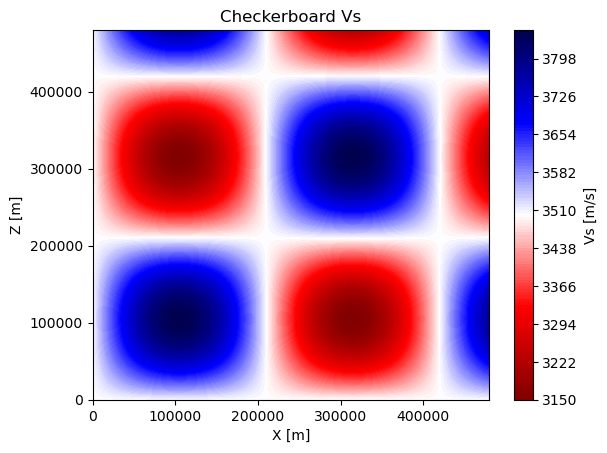

In [9]:
# Plotting Vs
plt.tricontourf(chkbd_x, chkbd_z, chkbd_vs, levels=125, cmap="seismic_r")
plt.xlabel("X [m]")
plt.ylabel("Z [m]")
plt.title("Checkerboard Vs")
plt.colorbar(label="Vs [m/s]")

- **red/warm** colors equal *relatively* **slow** velocities
- **blue/cold** colors equal *relatively* **fast** velocities
- This is typically the color convention scheme we use in seismic imaging

### c) Visualizing Source-Receiver Geometry

- As with Day 1B we can plot the SOURCES and STATIONS to see what the experiemental setup looks like with respect to the Checkerboard model. 
- These are the same Sources and Stations we plotted on top of the homogeneous halfspace model
- We will make multiple of the same plot to emphasize source and receiver names

Text(0.5, 1.0, 'SOURCE-RECEIVER GEOMETRY')

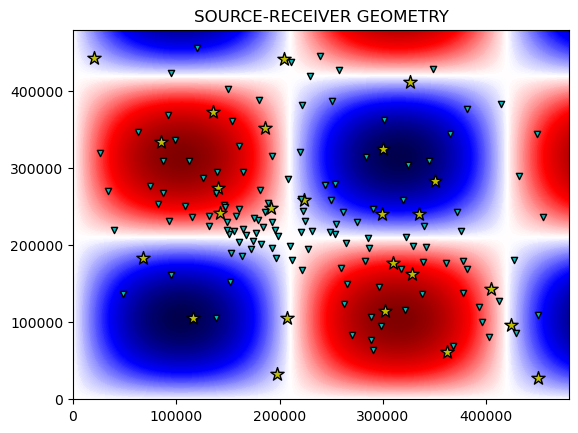

In [10]:
# Grab coordinates from STATIONS file
sta_x, sta_z = np.genfromtxt("DATA/STATIONS_checker", dtype=float, usecols=[2, 3]).T

# Grab coordinates from SOURCE files
ev_x, ev_z = [], []
for i in range(1, 26):
    source_file = f"DATA/SOURCE_{i:0>3}"
    with open(source_file, "r") as f:
        lines = f.readlines()
    # Trying to break apart the following line
    # 'xs = 299367.72      # source location x in meters\n'
    xs = float(lines[2].split("=")[1].split("#")[0].strip())
    zs = float(lines[3].split("=")[1].split("#")[0].strip())
    
    ev_x.append(xs)
    ev_z.append(zs)
    
# Plot SOURCES and STATIONS on top of the checkerboard model
plt.tricontourf(chkbd_x, chkbd_z, chkbd_vs, levels=250, cmap="seismic_r")
plt.scatter(ev_x, ev_z, c="y", marker="*", s=100, edgecolor="k")
plt.scatter(sta_x, sta_z, c="c", marker="v", s=20, edgecolor="k")
plt.title("SOURCE-RECEIVER GEOMETRY")

Text(0.5, 1.0, 'SOURCES; N=25')

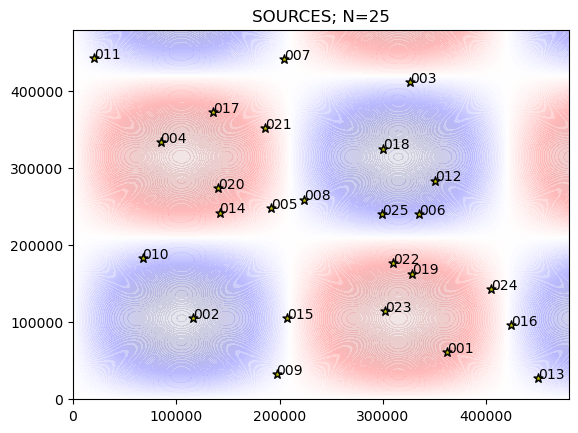

In [12]:
# Plot SOURCES next to source names
plt.tricontourf(chkbd_x, chkbd_z, chkbd_vs, levels=250, cmap="seismic_r", alpha=0.1)
for i, (x, z) in enumerate(zip(ev_x, ev_z)):
    plt.scatter(x, z, c="y", marker="*", edgecolor="k", s=45)
    plt.text(x, z, f"{i+1:0>3}")  # SOURCE numbering starts at 1
plt.title(f"SOURCES; N={len(ev_x)}")

Text(0.5, 1.0, 'STATIONS; N=132')

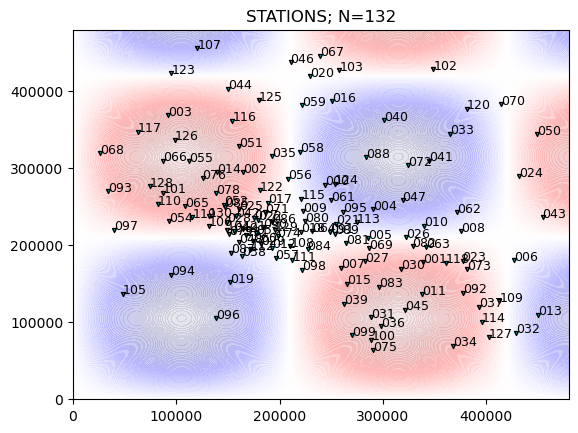

In [13]:
# Plot SOURCES and STATIONS together. Annotate names
plt.tricontourf(chkbd_x, chkbd_z, chkbd_vs, levels=250, cmap="seismic_r", alpha=0.1)
for i, (x, z) in enumerate(zip(sta_x, sta_z)):
    plt.scatter(x, z, c="c", marker="v", s=8, edgecolor="k")
    plt.text(x, z, f"{i:0>3}", fontsize=9)
plt.title(f"STATIONS; N={len(sta_x)}")

#### Understanding Source-Receiver Figures

- In the above figures, the upside-down blue triangles represent the 132 receivers in this example
- The 25 yellow stars are the sources. 
- Red colors in the checkerboard model represent **slow** velocities with respect to the starting homogeneous halfspace model
- Blue colors in the checkerboard model represent **fast** velocities with respect to the starting homogeneous halfspace model
- Now that we are familiar with our experimental setup, we can run SPECFEM2D to generate synthetics.

---------------
## 2) Setting up an Adjoint Simulation

#### Useful Definitions
- `Adjoint simulation`: simulates the interaction of a forward wavefield and an adjoint wavefield
- `Forward wavefield`: the seismic wavefield propagated from the source location
- `Adjoint wavefield`: a wavefield that propagates from receiver locations, whos time-dependent amplitude is controlled by adjoint sources
!!! - `Adjoint source`: time-dependent representations of waveform misfit. They are generated by comparing two sets of similar waveforms using a `misfit function`
- Each component of each receiver therefore is capable of generating an adjoint source
- The adjoint wavefield is a summation of adjoint sources generated from each receiver
- The volumetric integration of the interaction between the forward and adjoint wavefields creates a `misfit kernel`
- `Misfit kernels` illuminate the parts of the model that the misfit function is sensitive to.  
- That is, if we perturb the model in regions highlighted by the misfit kernels, we can affect the misfit function (i.e., data-synthetic comparison)
- Below we will illustrate the generation of a misfit kernel

In [ ]:
%cd /home/scoped/work/day_2/specfem2d_workdir

### a) Generating 'Data' with a Target Model

- We use the Checkerboard model shown above as a `True` or `Target` model. 
- The `Target` model is used to generate synthetic waveforms that are meant to approximate real world data. 
- In the case of a real seismic inversion, one would substitute these data with actual waveforms recorded during an earthquake. 
- In the absence of data, we use synthetic waveforms, making it easier to control the synthetic setup.
- We will choose a single source and a single receiver to generate our misfit kernel
- Because we have covered this in Day 1, we will quickly move through forward simulations through the Target model

In [ ]:
# > Choose your SOURCE here. By default we choose SOURCE_001
! cp DATA/SOURCE_001 DATA/SOURCE

In [ ]:
# > Choose your STATION here. By default we choose STATION 1
STATION_NUMBER_CHOICE = 0

# Read the existing stations file
stations = open("DATA/STATIONS_checker", "r").readlines()

# Write out only User defined stations
with open("DATA/STATIONS", "w") as f:
    f.write(stations[STATION_NUMBER_CHOICE])

In [ ]:
# Copy the Parameter file and make some adjustments 
! cp -f DATA/Par_file_Tape2007_132rec_checker DATA/Par_file

! seisflows sempar -P DATA/Par_file nproc 1
! seisflows sempar -P DATA/Par_file NSTEP 5000  # to match the other Par_file
! seisflows sempar -P DATA/Par_file save_model binary
! seisflows sempar -P DATA/Par_file setup_with_binary_database 1

# Ensure that SPECFEM can find the checkerboard model by naming it correctly
! cp -f DATA/model_velocity.dat_checker DATA/proc000000_model_velocity.dat_input

# Run Meshfem and SPECFEM SPECFEM2D 
! mpirun -n 1 bin/xmeshfem2D > OUTPUT_FILES/output_mesher.txt
! mpirun -n 1 bin/xspecfem2D > OUTPUT_FILES/output_solver.txt

In [ ]:
# We can look at the 'Data' waveform using SeisFlows
! ls OUTPUT_FILES/*semd
! seisflows plotst OUTPUT_FILES/AA.S000000.BXY.semd --savefig AA.S000000.BXY.semd.png
Image("AA.S000000.BXY.semd.png")

In [ ]:
# Lets rename the OUTPUT_FILES so that our subsequent run doesn't overwrite files
! mv OUTPUT_FILES OUTPUT_FILES_TRUE
! mkdir OUTPUT_FILES

### b) Generating Synthetics using Initial Model

- Now we want to generate a synthetic waveform using our starting or initial model. 
- In this example we will use the homogeneous halfspace model as our starting model in order to generate our synthetic waveform. 
- We use the **same** source and receivers as the Target model, to ensure that we can compare the waveforms generated.
- The idea here is that the waveform generated by the Target model and the waveform generated by the Initial model will be different
- Waveform differences contain information about the differences in the models that created them (in this case, homogeneous halfspace vs. checkerboard model).

In [ ]:
# The SOURCE and STATIONS files should remain the same,
# we only want to tell SPECFEM to use the homogeneous halfspace model
! cp -f DATA/Par_file_Tape2007_onerec DATA/Par_file

# Set some Par_file parameters to match the previous run
! seisflows sempar -P DATA/Par_file nproc 1
! seisflows sempar -P DATA/Par_file use_existing_stations .true.
! seisflows sempar -P DATA/Par_file save_model binary
! seisflows sempar -P DATA/Par_file setup_with_binary_database 1
! seisflows sempar -P DATA/Par_file save_forward .true.

# Run SPECFEM with the homogeneous halfspace model, defined in the Par_file
! mpirun -n 1 bin/xmeshfem2D > OUTPUT_FILES/output_mesher.txt
! mpirun -n 1 bin/xspecfem2D > OUTPUT_FILES/output_solver.txt

#### Parameter changes explained

- The parameters we have changed are the same as what we explained in Day 1. 
- However we have a new parameter `save_forward`.
- The `save_forward` parameter tells SPECFEM to save a snapshot of the last frame of the wavefield
- This snapshot is used to back-construct the forward wavefield during an adjoint simulation

In [ ]:
# Again we can look at the waveform. We will compare in the next section
! ls OUTPUT_FILES/*semd
! seisflows plotst OUTPUT_FILES/AA.S000000.BXY.semd --savefig AA.S000000.BXY.semd.png
Image("AA.S000000.BXY.semd.png")

In [ ]:
# Once again we rename the OUTPUT_FILES so that our subsequent run doesn't overwrite files
! cp -r OUTPUT_FILES OUTPUT_FILES_INIT

### c) Misfit Quantification and Adjoint Sources

- We use the term `misfit` to define differences between data and synthetics
- Adjoint sources are waveforms proportional to the time-dependent misfit
- The chosen misfit function directly affects seismic imaging studies by
- There are a large number of different misfit functions available, which compare e.g., phase, amplitude, frequency content, waveform envelopes
- To keep things simple, we use a waveform difference misfit function in this notebook
- We start out by plotting the two waveforms together to see how they differ. 

In [ ]:
# Read in the two-column ASCII files using NumPy where - t=time; d=data
t_init, d_init = np.loadtxt("OUTPUT_FILES_INIT/AA.S000000.BXY.semd").T
t_true, d_true = np.loadtxt("OUTPUT_FILES_TRUE/AA.S000000.BXY.semd").T

# Plot both waveforms using Matplotlib
plt.plot(t_init, d_init, c="r", label="MODEL INIT; SYNTHETIC")
plt.plot(t_true, d_true, c="k", label="MODEL TRUE; 'DATA'")
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")
plt.legend()
plt.show()

#### Comments on Default Waveform Figure

- From the figure above we can see that the `TRUE` synthetic shows a phase delay (negative time shift) with respect to the `INIT` synthetic. 
- This makes sense if we look at the checkerboard model, which perturbs the initial model in a positive direction (i.e., the `TRUE` model is faster, with respect to the `INIT` model).
- If you have chosen a different source or receiver, try to see if the waveform differences (or lack there of) make sense with respect to the checkerboard model we showed above

#### Misfit Quantification with Python

- We acknowledge that some of this work is modified from Ridvan Orsvuran's [Jupyter Notebook](https://github.com/rdno/simple_2d_kernel/blob/main/Simple_Specfem2D_Kernel.ipynb)
- We want to quantify the misfit between the two seismograms. For this example problem we'll use a simple waveform misfit function, defined as: $ \chi = \frac{1}{2} \int [d(t)-s(t)]^2 dt~, $
- Where d(t) is the time-dependent 'data' waveform (black trace above), and s(t) is the time-dependent 'synthetic' waveform (red trace above).
- We can calculate the misfit using the data traces from above.
- In Python we will perform this integration using [Simpson's rule](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.integrate.simps.html).

In [ ]:
# Integrate using scipy
dt = t_true[1] - t_true[0]  # dt represents the time step
misfit = 1/2 * simps((d_true - d_init)**2, dx=dt)

print(f"misfit={misfit:.3E}")

#### Adjoint Source with Python

- The adjoint source is a time-dependent measure of misfit, which is used to run adjoint simulations. 
- The equation for the waveform-based adjoint source is given by: $f^\dagger (t) = s(t) - d(t)$
- Where d(t) is the time-dependent 'data' waveform (black trace above), and s(t) is the time-dependent 'synthetic' waveform (red trace above).
- We can calculate the adjoint source and plot it alongside our waveforms to visualize the time-dependent misfit between data and synthetic.

In [ ]:
# Calculate the adjoint source using data and synthetic
d_adj = d_init - d_true

# Plot both waveforms using Matplotlib
plt.plot(t_init, d_init, c="r", label="MODEL INIT; SYNTHETIC")
plt.plot(t_true, d_true, c="k", label="MODEL TRUE; 'DATA'")
plt.plot(t_init, d_adj, c="g", label="ADJOINT SOURCE")
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")
plt.xlim([50, 175])
plt.legend()
plt.show()

- We can see that the adjoint source is equal to 0 when the waveforms are the same, and peaks when the waveforms are the most different. 
- The adjoint source will be fed in at receiver locations during an adjoint simulation
- The resulting adjoint wavefield will interact with the forward wavefield to illuminate parts of the model that the misfit function is sensitive to.

## 3) Running an Adjoint Simulation

- To run an adjoint simulation in SPECFEM2D, we need to make a few changes to the parameter file
- Similarly we need to set up some directories so that `xspecfem2D` can find our adjoint source

!!! TODO HOW DOES SPECFEM3D differ, also maybe some more explanation here !!!

In [ ]:
%cd /home/scoped/work/day_2/specfem2d_workdir

In [ ]:
! seisflows sempar -P DATA/Par_file simulation_type 3
! seisflows sempar -P DATA/Par_file save_ASCII_kernels .false.

#### Parameter file changes
`simulation_type`: Simulation type 3 tells SPECFEM that we are running an adjoint simulation  
`save_ASCII_kernels`: Tells SPECFEM to save the resulting misfit kernel in binary format (not ASCII)

### a) Writing Adjoint Sources

**IMPORTANT:** SPECFEM expects adjoint sources in a directory called `SEM/` with a specific format and filename

- Adjoint sources should be defined in the same way that the synthetics have been created. 
- In this case that means two-column ASCII files where the time axis exactly matches the the synthetic outputs. 
- Filename must also match synthetics, but with a `.adj` suffix; i.e., for synthetic `AA.S000000.BXY.semd`, corresponding adjoint source is: `AA.S000000.BXY.adj`.
- We can use Python to write this out in the correct location.

In [ ]:
# Make the requisite SEM/ directory
! mkdir SEM/

# Generate the two-column (time, data) format required
adjoint_source = np.vstack((t_init, d_adj)).T

# Save the .adj file as an ASCII file
np.savetxt("SEM/AA.S000000.BXY.adj", adjoint_source)
! head SEM/AA.S000000.BXY.adj

### b) Run `xspecfem2D`

- Now that we have the requisite setup in the `Par_file`, and the `SEM/` directory with the `.adj` adjoint source files, we can run the solver `xspecfem2D`. 
- We do **not** need to re-run the mesher as the adjoint simulations will run on the **same** numerical mesh that we used for our solver.

In [ ]:
! mpirun -n 1 bin/xspecfem2D > OUTPUT_FILES/output_adjsolver.txt

In [ ]:
# The adjoint solver also produces an informative log file
! head OUTPUT_FILES/output_adjsolver.txt

In [ ]:
# We can tell this is an adjoint simulation because SPECFEM considers adjoint sources
! head -338 OUTPUT_FILES/output_adjsolver.txt | tail -n 5

### c) Understanding Adjoint Simulation Outputs

- Adjoint simulations generate kernel files in the same format as the Databases and model files
- Kernels are generated for each quantity that defines the model

#### Misfit Kernels

- The most important output of the adjoint simulation is the misfit kernel.
- These files are named something like `proc*_alpha_kernel.bin`. 
- Kernels define the volumentric integration of the interaction between the forward wavefield and the adjoint wavefield. 
- We can look at the kernels for various quantities
- Kernel name `alpha` corresponds to $V_p$ and `beta` corresponds to $V_s$. 
- Just to make these quantities more intuitive (and to play nice with SeisFlows), we'll rename these kernels.

In [ ]:
# Move the kernels so they don't get overwritten
! mkdir KERNELS
! cp -r DATA/*.bin KERNELS
! cp OUTPUT_FILES/proc000000_alpha_kernel.bin KERNELS/proc000000_vp_kernel.bin 
! cp OUTPUT_FILES/proc000000_beta_kernel.bin KERNELS/proc000000_vs_kernel.bin 

In [ ]:
# Use SeisFlows to visualize the kernel
m = Model("KERNELS")
m.plot2d("vs_kernel", show=False)

# Small code snippet to grab coordinates from SOURCE files
source_file = f"DATA/SOURCE"
with open(source_file, "r") as f:
    lines = f.readlines()
ev_x = float(lines[2].split("=")[1].split("#")[0].strip())
ev_z = float(lines[3].split("=")[1].split("#")[0].strip())

# Small code snippet to grab coordinates from STATIONS file
sta_x, sta_z = np.genfromtxt("DATA/STATIONS", dtype=float, usecols=[2, 3]).T

# Plot source and receiver on the kernel figure
plt.scatter(ev_x, ev_z, c="y", marker="*", s=200, edgecolor="k")
plt.scatter(sta_x, sta_z, c="c", marker="v", s=100, edgecolor="k")

!!! TO DO Explain the kernel image above, !!!

#### Adjoint Images

- SPECFEM2D also produces adjoint images which document the adjoint wavefield.
- These do not show the interaction, but rather adjoint source emanating from the receiver location
- This adjoint wavefield interacts with the forward wavefield to generate the kernel we see above

In [ ]:
Image("OUTPUT_FILES/adjoint_image000000200.jpg")

In [ ]:
Image("OUTPUT_FILES/adjoint_image000000800.jpg")

## 4) Smoothing/Regularizing Kernels

- The kernel above contains all the frequency content of the forward-adjoint wavefield interaction
- There are many instances in which you might want to regularize a kernel
- For example, if your data is band-limited, you may know that you don't have sensitivity to small-scale perturbations
- Similarly, due to numerical discretization, areas around the source and receiver will have very large-amplitude, high-frequency kernels
- It is often desired to smooth away these small-scale perturbations to get at large-scale structure
- Similarly in seismolog, we band-limit data to focus in on certain length scales
- We use the SPECFEM executable `xsmooth_sem` to convolve our kernel with a 2D Gaussian
- We choose the X and Z half-widths of this Gaussian

In [ ]:
# In order to smooth waveforms, we use `xsmooth_sem`. If we run without arguments, we get the USAGE
! mpirun -n 1 bin/xsmooth_sem

 The usage of `xsmooth_sem` is given as
 ```bash
 USAGE:  mpirun -np NPROC bin/xsmooth_sem SIGMA_H SIGMA_V KERNEL_NAME INPUT_DIR OUPUT_DIR GPU_MODE
 ```
 We will need to choose values and directories to make this work
  - `SIGMA_H`: Horizontal smoothing length [m] representing the horizontal half-width of the Gaussian  
  - `SIGMA_Z`: Vertical smoothing length [m] representing the vertical half-width of the Gaussian  
  - `KERNEL_NAME`: The name of the kernel we want to smooth. Must match filename, so `proc000000_vs_kernel.bin` will correspond to kernel name `vs_kernel`  
  - `INPUT_DIR`: where SPECFEM can find the kernel files
  - `OUTPUT_DIR`: Where SPECFEM should output the SMOOTHED kernels 
  - `GPU_MODE`: Use GPU acceleration to speed up the smoothing operation (.true. or .false.)

In [ ]:
! mpirun -n 1 bin/xsmooth_sem 5000 5000 vs_kernel KERNELS/ KERNELS/ .false.

In [ ]:
# Smoothed kernels are renamed <KERNEL_NAMEL>_smooth
! ls KERNELS

# Rename kernel files so we can plot the smooth version with SeisFlows
! mv KERNELS/proc000000_vs_kernel.bin KERNELS/proc000000_vs_kernel_raw.bin
! mv KERNELS/proc000000_vs_kernel_smooth.bin KERNELS/proc000000_vs_kernel.bin

# Use SeisFlows to visualize the kernel
m = Model("KERNELS")
m.plot2d("vs_kernel", show=False)

# Plot source and receiver on the kernel figure
plt.scatter(ev_x, ev_z, c="y", marker="*", s=200, edgecolor="k")
plt.scatter(sta_x, sta_z, c="c", marker="v", s=100, edgecolor="k")

#### Comparing RAW and SMOOTHED kernels

- We can compare the kernel above with the raw kernel we showed before
- The amplitudes of the smoothed kernel are **smaller** than the raw kernel
- The smoothed kernel looks visibly smoother
- Much more of the domain in the smoothed kernel shows amplitude of 0

## 5) Automating Adjoint Simulations with SeisFlows

- SeisFlows allows us to automate the entire procedure we just performed manually. 
- We will use the same example to generate a misfit kernel
- Because the actual example problem runs an entire inversion, we use the `stop_after` command to stop the inversion mid-workflow
- The example problem will produce a smoothed misfit kernel

In [ ]:
# make sure we're in an empty working directory
! mkdir -p /home/scoped/work/day_2/sfexample_2
%cd /home/scoped/work/day_2/sfexample_2

# Run the example and stop after adjoint simulation
! seisflows examples setup 2 -r /home/scoped/specfem2d --event_id 1 --nsta 1 --niter 1 --with_mpi
! seisflows par stop_after evaluate_gradient_from_kernels
! seisflows submit

The previous example cell will be complete after you see the log message 
```bash
2022-09-17 02:35:43 (I) | stop workflow at `stop_after`: evaluate_gradient_from_kernels
```

In [ ]:
# We can use SeisFlows to plot images of the models to confirm
! seisflows plot2d MODEL_INIT vs --savefig m_init_vs.png
Image("m_init_vs.png")

In [ ]:
# Target Checkerboard model
! seisflows plot2d MODEL_TRUE vs --savefig m_true_vs.png
Image("m_true_vs.png")

In [ ]:
# Target Checkerboard model
! seisflows plot2d GRADIENT_01 vs_kernel --savefig g_01_vs.png
Image("g_01_vs.png")

#### Understaing SeisFlows outputs

- Model and kernel files are stored in the output/ directory
- Within each solver directory we have run an adjoint simulation
- You can see the adjoint sources stored in `scratch/solver/*/traces/adj`
- Adjoint sources were created using a cross-correlation traveltime misfit (cc)
- The misfit kernel was smoothed with a 5km x 5km Gaussian
- We print parameters from the SeisFlows parameter file to show how these were controlled

In [ ]:
# Model and gradient files in the output/ directory
! ls output
! echo 
! ls output/MODEL_INIT/
! echo
! ls output/GRADIENT_01

In [ ]:
# Solver directories and their adjoint traces
! ls scratch/solver/001
! echo
! ls scratch/solver/001/traces
! echo
! ls scratch/solver/001/traces/adj

In [ ]:
# SeisFlows parameters which controlled our adjoint simulation
! seisflows par adj_src_type  # Adjoint Source Type
! seisflows par smooth_h  # Horizontal Smoothing Length
! seisflows par smooth_v  # Vertical Smoothing Length